In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import numpy as np, matplotlib.pyplot as plt, ipywidgets as W
from IPython.display import display

from lerobot.configs.policies import PreTrainedConfig
from lerobot.datasets.lerobot_dataset import LeRobotDataset
from lerobot.policies.factory import get_policy_class
from lerobot.utils.utils import get_safe_torch_device
from offline_policy_inference import run_model_inference

In [2]:
device = get_safe_torch_device("cuda", log=True)
POLICY_PATH = {
    "smolvla": "outputs/train/2025-07-20/13-31-51_smolvla_3_so101_test/checkpoints/060000/pretrained_model",
    "smolvla_50k": "outputs/train/2025-07-20/13-31-51_smolvla_3_so101_test/checkpoints/050000/pretrained_model",
    "smolvla_40k": "outputs/train/2025-07-20/13-31-51_smolvla_3_so101_test/checkpoints/040000/pretrained_model",
    "smolvla_30k": "outputs/train/2025-07-20/13-31-51_smolvla_3_so101_test/checkpoints/030000/pretrained_model",
    "smolvla_20k": "outputs/train/2025-07-20/13-31-51_smolvla_3_so101_test/checkpoints/020000/pretrained_model",
    "smolvla_10k": "outputs/train/2025-07-20/13-31-51_smolvla_3_so101_test/checkpoints/010000/pretrained_model",
    "act_chunk50": "outputs/train/2025-08-01/14-48-57_act_so101_test/checkpoints/020000/pretrained_model",
    "act": "outputs/train/2025-07-08/18-12-26_act_so101_test/checkpoints/020000/pretrained_model"
    }["smolvla"]


cfg = PreTrainedConfig.from_pretrained(POLICY_PATH)
policy_cls = get_policy_class(cfg.type)
policy = policy_cls.from_pretrained(POLICY_PATH)
_ = policy.to(device)

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


Reducing the number of VLM layers to 16 ...
Loading weights from local directory


In [3]:
episode_id = 0

DATASET_REPO_ID = {
    "act": "zaringleb/eval_binary_cube_homelab_so101_act_12",
    "smolvla": "zaringleb/eval_binary_cube_homelab_so101_smolvla_60k_with_teleop_log1",
    "train": "zaringleb/binary_cube_homelab_so101_3"
    }["smolvla"]

dataset = LeRobotDataset(repo_id=DATASET_REPO_ID)
print(f"Loaded dataset '{DATASET_REPO_ID}' with {len(dataset)} frames and {dataset.num_episodes} episodes.")

ep = torch.stack(dataset.hf_dataset["episode_index"])
first = torch.nonzero(ep == episode_id, as_tuple=False)[0].item()
last = torch.nonzero(ep == episode_id, as_tuple=False)[-1].item()


"""Loads a dataset to visualises the actions and states of a policy."""

actions_from_dataset = []
states_from_dataset = []

for idx in range(first, last + 1):
    frame = dataset[idx]
    actions_from_dataset.append(frame["action"].cpu().numpy())
    states_from_dataset.append(frame["observation.state"].cpu().numpy())

actions_from_dataset = np.array(actions_from_dataset)
states_from_dataset = np.array(states_from_dataset)

Loaded dataset 'zaringleb/eval_binary_cube_homelab_so101_smolvla_60k_with_teleop_log1' with 1065 frames and 1 episodes.


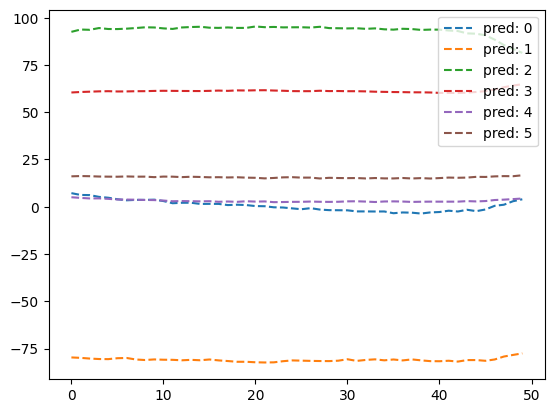

In [4]:
predicted_actions = []
start, stop = 0, 250
for frame_index_inside_episode in range(start, stop):
    sample = dataset[first + frame_index_inside_episode]
    predicted_actions.append(run_model_inference(policy, observation=sample, device=device)[0][0, :, :]) # batch, chunk, dof

predicted_actions = torch.stack(predicted_actions)


for dof in range(predicted_actions.shape[-1]):
   plt.plot(predicted_actions[0, :, dof], "--", label=f"pred: {dof}")

plt.legend(loc="upper right")

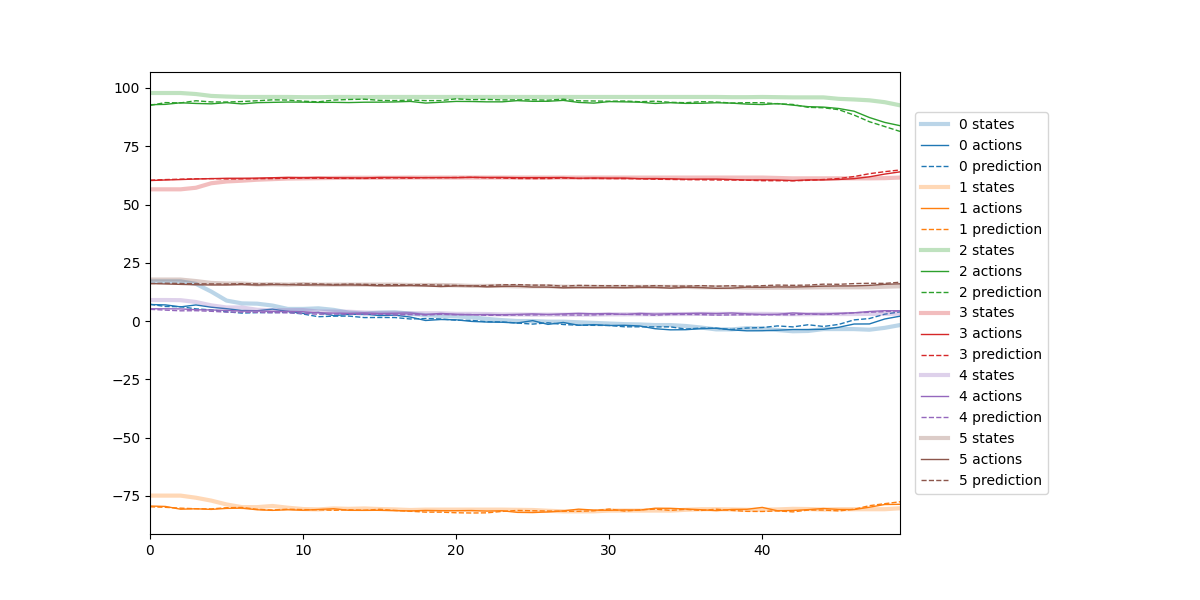

In [5]:
%matplotlib widget

frame_index_inside_episode = 0
D = actions_from_dataset.shape[-1]
T = predicted_actions.shape[1]

fig, ax = plt.subplots(figsize=(12, 6))
action_lines, state_lines, pred_lines = [], [], []

def init_plot():
    s = frame_index_inside_episode
    x = s + np.arange(T)
    for dof in range(D):
        color = f"C{dof}"
        state_lines.append(ax.plot(x, states_from_dataset[s:s+T, dof],
                                   label=f"{dof} states", color=color, linestyle="-", lw=3, alpha=0.3)[0])
        action_lines.append(ax.plot(x, actions_from_dataset[s:s+T, dof],
                                    label=f"{dof} actions", color=color, linestyle="-", lw=1)[0])
        pred_lines.append(ax.plot(x, predicted_actions[s, :, dof],
                                  label=f"{dof} prediction", color=color, linestyle="--", lw=1)[0])
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    fig.subplots_adjust(right=0.75)
    ax.set_xlim(s, s + T - 1)

init_plot()

btn_prev = W.Button(description="<-")
btn_next = W.Button(description="->")
frame_txt = W.IntText(value=frame_index_inside_episode, description="frame", disabled=True)

max_start = min(actions_from_dataset.shape[0] - T,
                states_from_dataset.shape[0] - T,
                predicted_actions.shape[0] - 1)

def update_plot():
    s = frame_index_inside_episode
    x = s + np.arange(T)
    for dof in range(D):
        action_lines[dof].set_ydata(actions_from_dataset[s:s+T, dof])
        action_lines[dof].set_xdata(x)
        state_lines[dof].set_ydata(states_from_dataset[s:s+T, dof])
        state_lines[dof].set_xdata(x)
        pred_lines[dof].set_ydata(predicted_actions[s, :, dof])
        pred_lines[dof].set_xdata(x)
    ax.set_xlim(s, s + T - 1)
    frame_txt.value = s
    fig.canvas.draw_idle()

@btn_prev.on_click
def _(_):
    global frame_index_inside_episode
    frame_index_inside_episode = max(frame_index_inside_episode - 1, 0)
    update_plot()

@btn_next.on_click
def _(_):
    global frame_index_inside_episode
    frame_index_inside_episode = min(frame_index_inside_episode + 1, max_start)
    update_plot()

display(W.HBox([btn_prev, btn_next, frame_txt]))

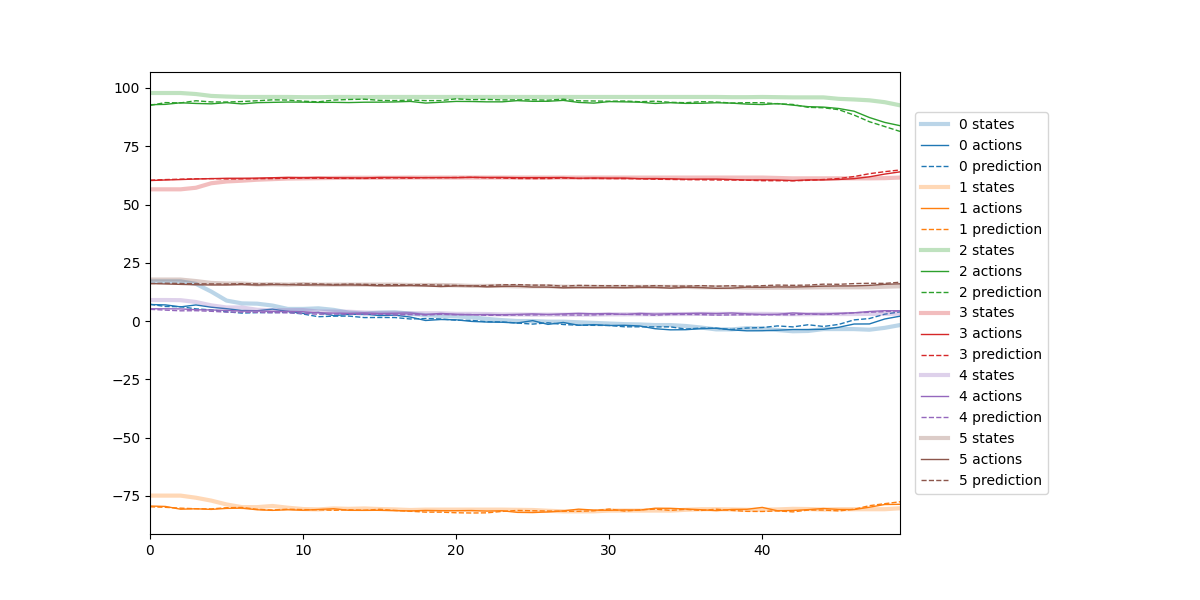

In [51]:
%matplotlib widget

frame_index_inside_episode = 0
D = actions_from_dataset.shape[-1]
T = predicted_actions.shape[1]

fig, ax = plt.subplots(figsize=(12, 6))
action_lines, state_lines, pred_lines = [], [], []

def init_plot():
    s = frame_index_inside_episode
    x = s + np.arange(T)
    for dof in range(D):
        color = f"C{dof}"
        state_lines.append(ax.plot(x, states_from_dataset[s:s+T, dof],
                                   label=f"{dof} states", color=color, linestyle="-", lw=3, alpha=0.3)[0])
        action_lines.append(ax.plot(x, actions_from_dataset[s:s+T, dof],
                                    label=f"{dof} actions", color=color, linestyle="-", lw=1)[0])
        pred_lines.append(ax.plot(x, predicted_actions[s, :, dof],
                                  label=f"{dof} prediction", color=color, linestyle="--", lw=1)[0])
    ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)
    fig.subplots_adjust(right=0.75)
    ax.set_xlim(s, s + T - 1)

init_plot()

btn_prev = W.Button(description="<-")
btn_next = W.Button(description="->")
frame_txt = W.IntText(value=frame_index_inside_episode, description="frame", disabled=True)

max_start = min(actions_from_dataset.shape[0] - T,
                states_from_dataset.shape[0] - T,
                predicted_actions.shape[0] - 1)

def update_plot():
    s = frame_index_inside_episode
    x = s + np.arange(T)
    for dof in range(D):
        action_lines[dof].set_ydata(actions_from_dataset[s:s+T, dof])
        action_lines[dof].set_xdata(x)
        state_lines[dof].set_ydata(states_from_dataset[s:s+T, dof])
        state_lines[dof].set_xdata(x)
        pred_lines[dof].set_ydata(predicted_actions[s, :, dof])
        pred_lines[dof].set_xdata(x)
    ax.set_xlim(s, s + T - 1)
    frame_txt.value = s
    fig.canvas.draw_idle()

@btn_prev.on_click
def _(_):
    global frame_index_inside_episode
    frame_index_inside_episode = max(frame_index_inside_episode - 1, 0)
    update_plot()

@btn_next.on_click
def _(_):
    global frame_index_inside_episode
    frame_index_inside_episode = min(frame_index_inside_episode + 1, max_start)
    update_plot()

display(W.HBox([btn_prev, btn_next, frame_txt]))

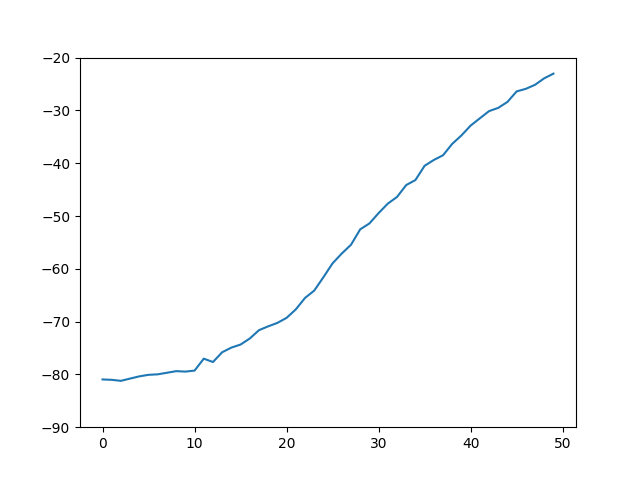

In [56]:

sample = dataset[first + 40]
predictions = run_model_inference(policy, observation=sample, device=device)
trj = predictions[1]
predictions = predictions[0][0, :, :] # batch, chunk, dof
predictions[:, 1]

plt.figure()                       # ensures a new figure
plt.plot(predictions[:, 1])
plt.ylim(-90, -20)
plt.show()


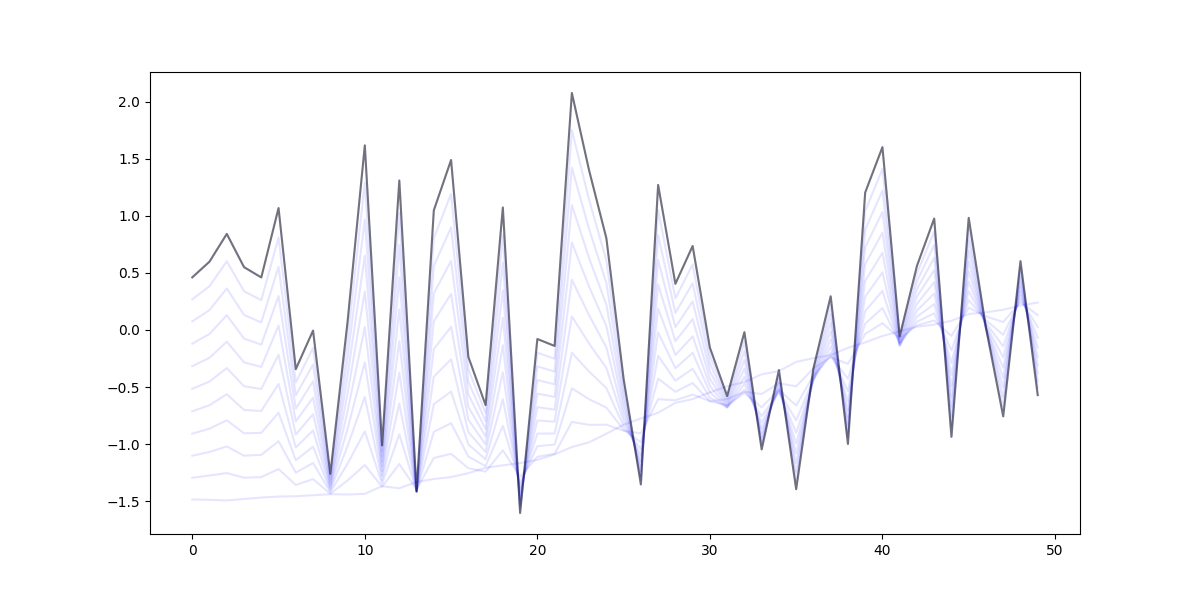

In [57]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(12, 6))                  # ensures a new figure

for step in range(len(trj)):
    ax.plot(trj[step][0, :, 1], color="blue", alpha=0.1)

line = ax.plot(trj[0][0, :, 1], color="black", alpha=0.5)[0]

step = 0

btn_prev = W.Button(description="<-")
btn_next = W.Button(description="->")
frame_txt = W.IntText(value=step, description="step", disabled=True)

def update_plot():
    line.set_ydata(trj[step][0, :, 1])
    frame_txt.value = step
    fig.canvas.draw_idle()

@btn_prev.on_click
def _(_):
    global step
    step = max(step - 1, 0)
    update_plot()

@btn_next.on_click
def _(_):
    global step
    step = min(step + 1, 10)
    update_plot()

display(W.HBox([btn_prev, btn_next, frame_txt]))